## Load everything

In [1]:
import yaml
import sys
import traceback
import logging
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

%matplotlib inline

from tqdm.notebook import tqdm
from typing import *

%load_ext autoreload
%autoreload 2

import os
current_dir = os.getcwd()
os.chdir("../src")
from dqnroute import *
os.chdir(current_dir)

logger = logging.getLogger(DQNROUTE_LOGGER)
TORCH_MODELS_DIR = '../torch_models'
LOG_DATA_DIR = '../logs/runs'
np.set_printoptions(linewidth=500)

_legend_txt_replace = {
    'networks': {
        'link_state': 'Shortest paths',
        'simple_q': 'Q-routing',
        'pred_q': 'PQ-routing',
        'glob_dyn': 'Global-dynamic',
        'dqn': 'DQN',
        'dqn_oneout': 'DQN (1-out)',
        'dqn_emb': 'DQN-LE',
        'centralized_simple': 'Centralized control'
    },
    'conveyors': {
        'link_state': 'Vyatkin-Black',
        'simple_q': 'Q-routing',
        'pred_q': 'PQ-routing',
        'glob_dyn': 'Global-dynamic',
        'dqn': 'DQN',
        'dqn_oneout': 'DQN (1-out)',
        'dqn_emb': 'DQN-LE',
        'centralized_simple': 'BSR'
    }
}

_targets = {'time': 'avg','energy': 'sum', 'collisions': 'sum'}

_ylabels = {
    'time': 'Mean delivery time',
    'energy': 'Total energy consumption',
    'collisions': 'Cargo collisions'
}

def print_sums(df):
    types = set(df['router_type'])
    for tp in types:
        x = df.loc[df['router_type']==tp, 'count'].sum()
        txt = _legend_txt_replace.get(tp, tp)
        print('  {}: {}'.format(txt, x))

def plot_data(data, meaning='time', figsize=(15,5), xlim=None, ylim=None,
              xlabel='Simulation time', ylabel=None,
              font_size=14, title=None, save_path=None,
              draw_collisions=False, context='networks', **kwargs):
    if 'time' not in data.columns:
        datas = split_dataframe(data, preserved_cols=['router_type', 'seed'])
        for tag, df in datas:
            if tag == 'collisions' and not draw_collisions:
                print('Number of collisions:')
                print_sums(df)
                continue
                
            xlim = kwargs.get(tag+'_xlim', xlim)
            ylim = kwargs.get(tag+'_ylim', ylim)
            save_path = kwargs.get(tag+'_save_path', save_path)
            plot_data(df, meaning=tag, figsize=figsize, xlim=xlim, ylim=ylim,
                      xlabel=xlabel, ylabel=ylabel, font_size=font_size,
                      title=title, save_path=save_path, context='conveyors')
        return 
    
    target = _targets[meaning]
    if ylabel is None:
        ylabel = _ylabels[meaning]
        
    fig = plt.figure(figsize=figsize)
    ax = sns.lineplot(x='time', y=target, hue='router_type', data=data,
                      err_kws={'alpha': 0.1})
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = list(map(lambda l: _legend_txt_replace[context].get(l, l), labels[1:]))
    ax.legend(handles=handles[1:], labels=new_labels, fontsize=font_size)
    
    ax.tick_params(axis='both', which='both', labelsize=int(font_size*0.75))
        
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    
    plt.show(fig)
    
    if save_path is not None:
        fig.savefig('../img/' + save_path, bbox_inches='tight')

def split_data(dct):
    results = []
    
    def add_res(i, key, val):
        while len(results) <= i:
            results.append({})
        results[i][key] = val
    
    for (key, vals) in dct.items():
        for (i, val) in enumerate(vals):
            add_res(i, key, val)
    return tuple(results)
    
def combine_launch_data(launch_data):
    dfs = []
    for (job_id, data) in launch_data.items():
        router_type, seed = un_job_id(job_id)
        df = data.copy()
        add_cols(df, router_type=router_type, seed=seed)
        dfs.append(df)
    return pd.concat(dfs, axis=0)

class DummyTqdmFile(object):
    """Dummy file-like that will write to tqdm"""
    file = None
    def __init__(self, file):
        self.file = file

    def write(self, x):
        # Avoid print() second call (useless \n)
        if len(x.rstrip()) > 0:
            tqdm.write(x, file=self.file)

    def flush(self):
        return getattr(self.file, "flush", lambda: None)()

@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err

## Run simulation

In [104]:
def run_single(file: str, router_type: str, random_seed: int, **kwargs):
    job_id = mk_job_id(router_type, random_seed)
    with tqdm(desc=job_id) as bar:
        queue = DummyProgressbarQueue(bar)
        runner = ConveyorsRunner(run_params=file, router_type=router_type,
                                 random_seed=random_seed, progress_queue=queue, **kwargs)
        event_series = runner.run(**kwargs)
    return event_series, runner

#scenario = '../launches/conveyor_energy_test.yaml'
#scenario = '../launches/conveyor_cyclic_energy_test.yaml'
scenario = '../launches/conveyor_cyclic2_energy_test.yaml'

event_series, runner = run_single(file=scenario, router_type='dqn_emb', progress_step=500,
                                  ignore_saved=[True], random_seed=44)

[ World      : 17736.087020163894s ] collision detected: (#888; 0m) with (#891; 0.994m) on conv 0
[ World      : 17994.007020163896s ] collision detected: (#901; 0m) with (#904; 0.994m) on conv 0



## Explore the graph and routers assigned to nodes

In [105]:
from router_graph import RouterGraph
g = RouterGraph(runner)

[<class 'dqnroute.simulation.conveyors.ConveyorsEnvironment'>, <class 'dqnroute.simulation.common.MultiAgentEnv'>, <class 'dqnroute.utils.HasLog'>, <class 'dqnroute.utils.HasTime'>]
node ('sink', 0) RouterSink
    router ('router', 12) DQNRouterEmbConveyor
node ('sink', 1) RouterSink
    router ('router', 13) DQNRouterEmbConveyor
node ('source', 0) RouterSource
    router ('router', 14) DQNRouterEmbConveyor
node ('source', 1) RouterSource
    router ('router', 15) DQNRouterEmbConveyor
node ('conveyor', 0) SimpleRouterConveyor
    router ('router', 10) DQNRouterEmbConveyor
node ('conveyor', 1) SimpleRouterConveyor
    router ('router', 6) DQNRouterEmbConveyor
    router ('router', 7) DQNRouterEmbConveyor
node ('conveyor', 2) SimpleRouterConveyor
    router ('router', 3) DQNRouterEmbConveyor
node ('conveyor', 3) SimpleRouterConveyor
    router ('router', 4) DQNRouterEmbConveyor
    router ('router', 11) DQNRouterEmbConveyor
node ('conveyor', 4) SimpleRouterConveyor
    router ('router', 

## Find the reachability matrix of the graph

In [106]:
g.print_reachability_matrix()

1011111111111111 # from ('source', 0)
0111111111111111 # from ('source', 1)
0011111111111111 # from ('diverter', 0)
0011111111111111 # from ('diverter', 1)
0011111111111111 # from ('diverter', 2)
0011111111111111 # from ('junction', 0)
0011111111111111 # from ('junction', 1)
0011111111111111 # from ('junction', 2)
0011111111111111 # from ('junction', 3)
0011111111111111 # from ('junction', 4)
0000000000111010 # from ('junction', 5)
0000000000011010 # from ('junction', 6)
0000000000001010 # from ('junction', 7)
0011111111111111 # from ('junction', 8)
0000000000000010 # from ('sink', 0)
0000000000000001 # from ('sink', 1)


## Visualize graph

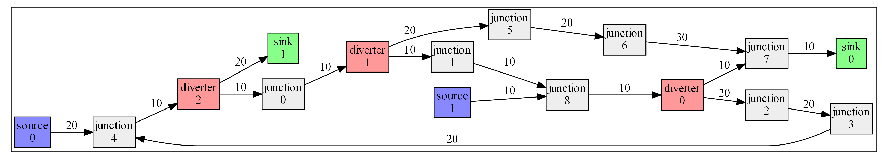

In [107]:
import pygraphviz as pgv

gv_graph = pgv.AGraph(directed=True)

def get_gv_node_name(node_key: AgentId):
    return f"{node_key[0]}\n{node_key[1]}"

for i, node_key in g.indices_to_node_keys.items():
    gv_graph.add_node(i)
    n = gv_graph.get_node(i)
    n.attr["label"] = get_gv_node_name(node_key)
    n.attr["shape"] = "box"
    n.attr["style"] = "filled"
    n.attr["fixedsize"] = "true"
    if node_key[0] == "source":
        n.attr["fillcolor"] = "#8888FF"
        n.attr["width"] = "0.6"
    elif node_key[0] == "sink":
        n.attr["fillcolor"] = "#88FF88"
        n.attr["width"] = "0.5"
    elif node_key[0] == "diverter":
        n.attr["fillcolor"] = "#FF9999"
        n.attr["width"] = "0.7"
    else:
        n.attr["fillcolor"] = "#EEEEEE"
        n.attr["width"] = "0.7"

for from_node in g.node_keys:
    i1 = g.node_keys_to_indices[from_node]
    for to_node in g.get_out_nodes(from_node):
        i2 = g.node_keys_to_indices[to_node]
        gv_graph.add_edge(i1, i2)
        e = gv_graph.get_edge(i1, i2)
        e.attr["label"] = g.get_edge_length(from_node, to_node)

prefix = "../img/tmp."
gv_graph.write(prefix + "gv")
for path in [prefix + "png", prefix + "pdf"]:
    gv_graph.draw(path, prog="dot", args="-Gdpi=300 -Gmargin=0 -Grankdir=LR")
fig, ax = plt.subplots(figsize=(15.5, 15.5))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
image = plt.imread(prefix + "png")
plt.imshow(image);

### Test routing from each source to each sink

* Routers are different from graph nodes
* At junctions, there are routers that do not have choice
* Other routeres are at diverters and they have only two choices
* During the real system operation, routeres behave stochastically

In [108]:
for source in g.sources:
    for sink in g.sinks:
        print(f"Testing delivery from {source} to {sink}...")
        current_node = source
        visited_nodes = set()
        sink_embedding, _, _ = g.node_to_embeddings(sink, sink)
        while True:
            if current_node in visited_nodes:
                print("    FAIL due to cycle")
                break
            visited_nodes.add(current_node)
            print("    in:", current_node)
            if current_node[0] == "sink":
                print("    ", end="")
                print("OK" if current_node == sink else "FAIL due to wrong destination")
                break
            elif current_node[0] in ["source", "junction"]:
                out_nodes = g.get_out_nodes(current_node)
                assert len(out_nodes) == 1
                current_node = out_nodes[0]
            elif current_node[0] == "diverter":
                current_embedding, neighbors, neighbor_embeddings = g.node_to_embeddings(current_node, sink)
                q_values = []
                for neighbor, neighbor_embedding in zip(neighbors, neighbor_embeddings):
                    with torch.no_grad():
                        q = g.q_forward(current_embedding, sink_embedding, neighbor_embedding).item()
                    print(f"        Q({current_node} -> {neighbor} | {sink}) = {q:.4f}")
                    q_values += [q]
                best_neighbor_index = np.argmax(np.array(q_values))
                current_node = neighbors[best_neighbor_index]
            else:
                raise AssertionError()

Testing delivery from ('source', 0) to ('sink', 0)...
    in: ('source', 0)
    in: ('junction', 4)
    in: ('diverter', 2)
        Q(('diverter', 2) -> ('junction', 0) | ('sink', 0)) = -122.5188
    in: ('junction', 0)
    in: ('diverter', 1)
        Q(('diverter', 1) -> ('junction', 1) | ('sink', 0)) = -36.7499
        Q(('diverter', 1) -> ('junction', 5) | ('sink', 0)) = -41.2630
    in: ('junction', 1)
    in: ('junction', 8)
    in: ('diverter', 0)
        Q(('diverter', 0) -> ('junction', 2) | ('sink', 0)) = -91.0076
        Q(('diverter', 0) -> ('junction', 7) | ('sink', 0)) = -52.3326
    in: ('junction', 7)
    in: ('sink', 0)
    OK
Testing delivery from ('source', 0) to ('sink', 1)...
    in: ('source', 0)
    in: ('junction', 4)
    in: ('diverter', 2)
        Q(('diverter', 2) -> ('junction', 0) | ('sink', 1)) = -97.0175
        Q(('diverter', 2) -> ('sink', 1) | ('sink', 1)) = -8.0219
    in: ('sink', 1)
    OK
Testing delivery from ('source', 1) to ('sink', 0)...
    in:

## Search of adversarial examples to maximize delivery cost w.r.t. input embeddings

In [109]:
import sympy
from adversarial import PGDAdversary
from collections import OrderedDict
from ml_util import Util

adv = PGDAdversary(rho=1.5, steps=100, step_size=0.02, random_start=True, stop_loss=1e5, verbose=2,
                   norm="scaled_l_2", n_repeat=2, repeat_mode="min")

ACCOUNT_FOR_CONVEYOR_LENGTHS = True

def smooth(p, alpha: float):
    # smoothing
    # to get rid of 0 and 1 probabilities that lead to saturated gradients
    return p * (1 - alpha) + alpha / 2
    
for sink in g.sinks:
    print(f"Measuring robustness of delivery to {sink}...")
    # reindex nodes so that only the nodes from which the sink is reachable are considered
    # (otherwise, the solution will need to include infinite hitting times)
    reachable_nodes = [node_key for node_key in g.node_keys if g.reachable[node_key, sink]]
    print(f"  nodes from which {sink} is reachable: {reachable_nodes}")
    reachable_nodes_to_indices = {node_key: i for i, node_key in enumerate(reachable_nodes)}
    sink_index = reachable_nodes_to_indices[sink]
    print(f"  sink index = {sink_index}")
    system_size = len(reachable_nodes)
    
    reachable_diverters = [node_key for node_key in reachable_nodes if node_key[0] == "diverter"]
    reachable_diverters_to_indices = {node_key: i for i, node_key in enumerate(reachable_diverters)}
    
    reachable_sources = [node_key for node_key in reachable_nodes if node_key[0] == "source"]
    
    params = sympy.symbols([f"p{i}" for i in range(len(reachable_diverters))])
    print(f"  parameters: {params}")

    matrix = [[0 for _ in range(system_size)] for _ in range(system_size)]
    bias = [[0] for _ in range(system_size)]

    # fill the system of linear equations
    for i in range(system_size):
        node_key = reachable_nodes[i]
        matrix[i][i] = 1
        if i == sink_index:
            # zero hitting time for the target sink
            assert node_key[0] == "sink"
        elif node_key[0] in ["source", "junction", "diverter"]:
            next_node_keys = [node_key for node_key in g.get_out_nodes(node_key) if g.reachable[node_key, sink]]
            if not ACCOUNT_FOR_CONVEYOR_LENGTHS:
                bias[i][0] = 1
            if len(next_node_keys) == 1:
                # only one possible destination
                # either sink, junction, or a diverter with only one option due to reachability shielding
                next_node_key = next_node_keys[0]
                matrix[i][reachable_nodes_to_indices[next_node_key]] = -1
                if ACCOUNT_FOR_CONVEYOR_LENGTHS:
                    bias[i][0] = g.get_edge_length(node_key, next_node_key)
            elif len(next_node_key) == 2:
                # two possible destinations
                k1, k2 = next_node_keys[0], next_node_keys[1]
                p = params[reachable_diverters_to_indices[node_key]]
                print(f"      {p} = P({node_key} -> {k1})" )
                print(f"  1 - {p} = P({node_key} -> {k2})" )
                if k1 != sink:
                    matrix[i][reachable_nodes_to_indices[k1]] = -p
                if k2 != sink:
                    matrix[i][reachable_nodes_to_indices[k2]] = p - 1
                if ACCOUNT_FOR_CONVEYOR_LENGTHS:
                    bias[i][0] = g.get_edge_length(node_key, k1) * p + g.get_edge_length(node_key, k2) * (1 - p)
            else:
                assert False
        else:
            assert False
            
    matrix = sympy.Matrix(matrix)
    #print(f"  matrix: {matrix}")
    bias = sympy.Matrix(bias)
    print(f"  bias: {bias}")
    solution = matrix.inv() @ bias
    #print(f"  solution: {solution}")
    
    sink_embedding, _, _ = g.node_to_embeddings(sink, sink)
    embedding_size = sink_embedding.flatten().shape[0]
    # gather all embeddings that we need to compute the objective
    stored_embeddings = OrderedDict({sink: sink_embedding})
    for diverter in reachable_diverters:
        diverter_embedding, neighbors, neighbor_embeddings = g.node_to_embeddings(diverter, sink)
        stored_embeddings[diverter] = diverter_embedding
        for neighbor, neighbor_embedding in zip(neighbors, neighbor_embeddings):
            stored_embeddings[neighbor] = neighbor_embedding
    
    def pack_embeddings(embedding_dict: OrderedDict) -> torch.tensor:
        return torch.cat(tuple(embedding_dict.values())).flatten()

    def unpack_embeddings(embedding_vector: torch.tensor) -> OrderedDict:
        embedding_dict = OrderedDict()
        for i, (key, value) in enumerate(stored_embeddings.items()):
            embedding_dict[key] = embedding_vector[i*embedding_size:(i + 1)*embedding_size]\
                .reshape(1, embedding_size)
        return embedding_dict
    
    initial_vector = pack_embeddings(stored_embeddings)
    
    for source in reachable_sources:
        print(f"  Measuring robustness of delivery from {source} to {sink}...")
        source_index = g.node_keys_to_indices[source]
        symbolic_objective = sympy.simplify(solution[source_index])
        print(f"    expected delivery cost from {source} = {symbolic_objective}")
        objective = sympy.lambdify(params, symbolic_objective)        

        def get_gradient(x: torch.tensor, smoothing_alpha: float) -> Tuple[torch.tensor, float, str]:
            """
            :param x: parameter vector (the one expected to converge to an adversarial example)
            :param smoothing_alpha: smooth probabilities with this small positive number
            Returns a tuple (gradient pointing to the direction of the adversarial attack,
                                the corresponding loss function value,
                                auxiliary information for printing during optimization)."""
            #assert not torch.isnan(x).any()
            x = Util.optimizable_clone(x.flatten())
            embedding_dict = unpack_embeddings(x)
            objective_inputs = []
            perturbed_sink_embeddings = embedding_dict[sink].repeat(2, 1)
            # source embedding does not influence the decision, use default value:
            for diverter in reachable_diverters:
                perturbed_diverter_embeddings = embedding_dict[diverter].repeat(2, 1)
                _, current_neighbors, _ = g.node_to_embeddings(diverter, sink)
                perturbed_neighbor_embeddings = torch.cat([embedding_dict[current_neighbor]
                                                           for current_neighbor in current_neighbors])
                q_values = g.q_forward(perturbed_diverter_embeddings, perturbed_sink_embeddings,
                                       perturbed_neighbor_embeddings).flatten()
                #assert not torch.isnan(q_values).any()
                propabilities = (q_values / MIN_TEMP).softmax(dim=0)
                first_p = smooth(propabilities[0], smoothing_alpha)
                objective_inputs += [first_p]
            objective_value = objective(*objective_inputs)
            #print(objective_value.detach().cpu().numpy())
            objective_value.backward()
            aux_info = [np.round(x.detach().cpu().item(), 4) for x in objective_inputs]
            aux_info = {param: value for param, value in zip(params, aux_info)}
            aux_info = f"param_values = {aux_info}"
            return x.grad, objective_value.item(), aux_info
        
        adv.perturb(initial_vector, get_gradient)

Measuring robustness of delivery to ('sink', 0)...
  nodes from which ('sink', 0) is reachable: [('source', 0), ('source', 1), ('diverter', 0), ('diverter', 1), ('diverter', 2), ('junction', 0), ('junction', 1), ('junction', 2), ('junction', 3), ('junction', 4), ('junction', 5), ('junction', 6), ('junction', 7), ('junction', 8), ('sink', 0)]
  sink index = 14
  parameters: [p0, p1, p2]
      p0 = P(('diverter', 0) -> ('junction', 2))
  1 - p0 = P(('diverter', 0) -> ('junction', 7))
      p1 = P(('diverter', 1) -> ('junction', 1))
  1 - p1 = P(('diverter', 1) -> ('junction', 5))
  bias: Matrix([[20], [10], [10*p0 + 10], [20 - 10*p1], [10], [10], [10], [20], [20], [10], [20], [30], [10], [10], [0]])
  Measuring robustness of delivery from ('source', 0) to ('sink', 0)...
    expected delivery cost from ('source', 0) = (-20*p0*p1 + 30*p1 - 130)/(p0*p1 - 1)
>> #run = 0, ║x1║ = 3.69396, ρ = 1.50000
step   0: objective = 100.923729, ║Δx║ = 0.79836, ║x║ = 3.60196, param_values = {p0: 0.0049, p

In [110]:
filename = "saved-net-backup.bin"
torch.save(g.q_network.ff_net, filename)
g.q_network.ff_net = torch.load(filename)

## Examining delivery cost change after optimization steps

Measuring robustness of delivery to ('sink', 0)...
  parameters: [p0, p1, p2]
      p0 = P(('diverter', 0) -> ('junction', 2))
  1 - p0 = P(('diverter', 0) -> ('junction', 7))
      p1 = P(('diverter', 1) -> ('junction', 1))
  1 - p1 = P(('diverter', 1) -> ('junction', 5))
  Measuring robustness of delivery from ('source', 0) to ('sink', 0)...
    expected delivery cost from ('source', 0) = (-20*p0*p1 + 30*p1 - 130)/(p0*p1 - 1)


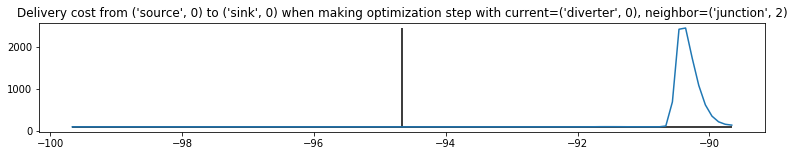

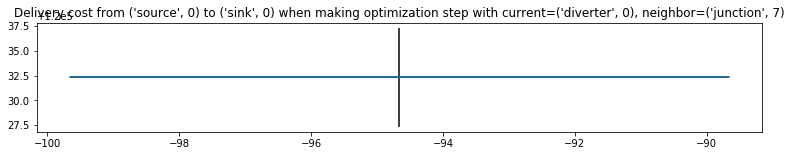

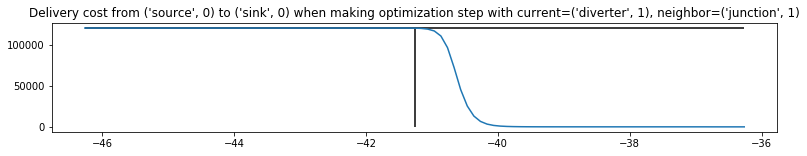

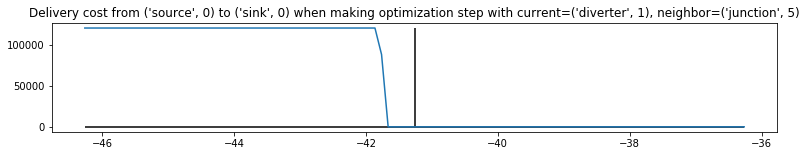

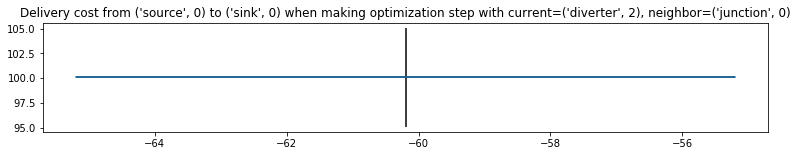

  Measuring robustness of delivery from ('source', 1) to ('sink', 0)...
    expected delivery cost from ('source', 1) = 10*(7*p0*p1 - 15*p0 - 4)/(p0*p1 - 1)


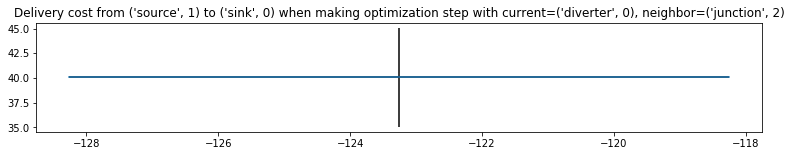

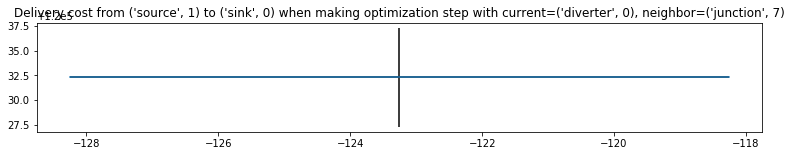

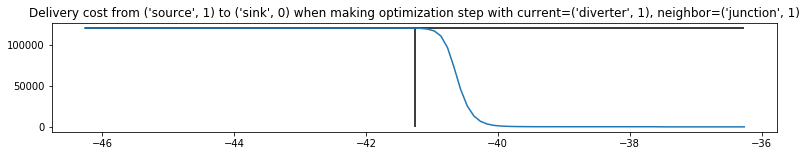

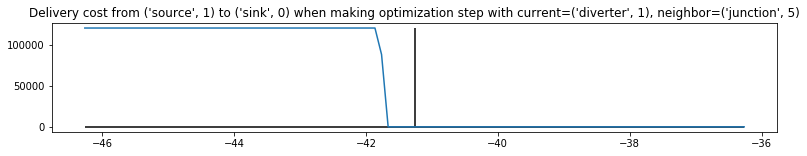

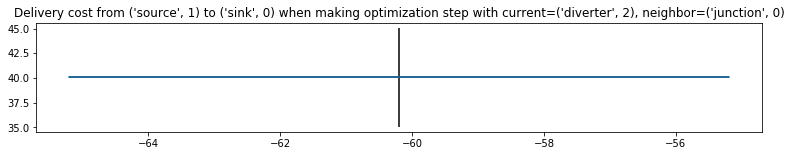

Measuring robustness of delivery to ('sink', 1)...
  parameters: [p0, p1, p2]
      p2 = P(('diverter', 2) -> ('junction', 0))
  1 - p2 = P(('diverter', 2) -> ('sink', 1))
  Measuring robustness of delivery from ('source', 0) to ('sink', 1)...
    expected delivery cost from ('source', 0) = -(70*p2 + 50)/(p2 - 1)


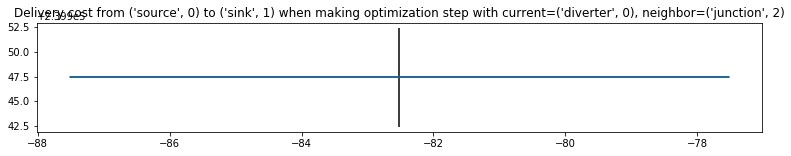

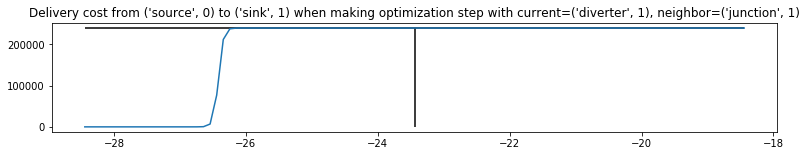

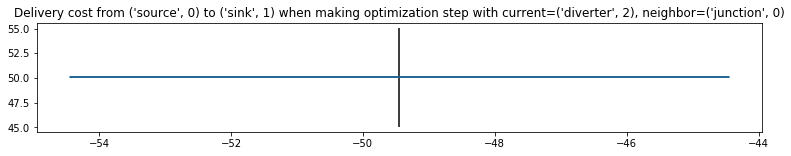

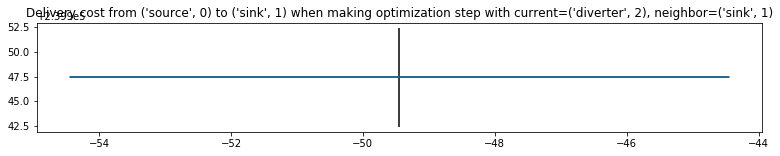

  Measuring robustness of delivery from ('source', 1) to ('sink', 1)...
    expected delivery cost from ('source', 1) = -(10*p2 + 110)/(p2 - 1)


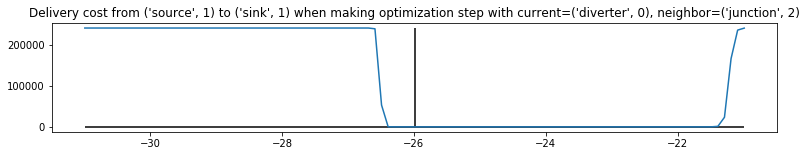

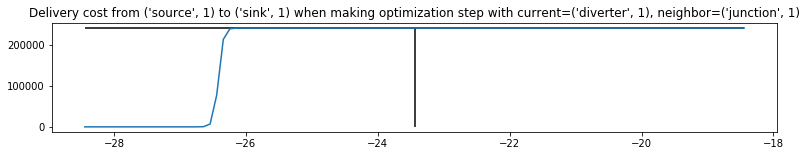

In [ ]:
smoothing_alpha = 0.001

for sink in g.sinks:
    print(f"Measuring robustness of delivery to {sink}...")
    # reindex nodes so that only the nodes from which the sink is reachable are considered
    # (otherwise, the solution will need to include infinite hitting times)
    reachable_nodes = [node_key for node_key in g.node_keys if g.reachable[node_key, sink]]
    reachable_nodes_to_indices = {node_key: i for i, node_key in enumerate(reachable_nodes)}
    sink_index = reachable_nodes_to_indices[sink]
    system_size = len(reachable_nodes)
    
    reachable_diverters = [node_key for node_key in reachable_nodes if node_key[0] == "diverter"]
    reachable_diverters_to_indices = {node_key: i for i, node_key in enumerate(reachable_diverters)}
    
    reachable_sources = [node_key for node_key in reachable_nodes if node_key[0] == "source"]
    
    params = sympy.symbols([f"p{i}" for i in range(len(reachable_diverters))])
    print(f"  parameters: {params}")

    matrix = [[0 for _ in range(system_size)] for _ in range(system_size)]
    bias = [[0] for _ in range(system_size)]

    # fill the system of linear equations
    for i in range(system_size):
        node_key = reachable_nodes[i]
        matrix[i][i] = 1
        if i == sink_index:
            # zero hitting time for the target sink
            assert node_key[0] == "sink"
        elif node_key[0] in ["source", "junction", "diverter"]:
            next_node_keys = [node_key for node_key in g.get_out_nodes(node_key) if g.reachable[node_key, sink]]
            if not ACCOUNT_FOR_CONVEYOR_LENGTHS:
                bias[i][0] = 1
            if len(next_node_keys) == 1:
                # only one possible destination
                # either sink, junction, or a diverter with only one option due to reachability shielding
                next_node_key = next_node_keys[0]
                matrix[i][reachable_nodes_to_indices[next_node_key]] = -1
                if ACCOUNT_FOR_CONVEYOR_LENGTHS:
                    bias[i][0] = g.get_edge_length(node_key, next_node_key)
            elif len(next_node_key) == 2:
                # two possible destinations
                k1, k2 = next_node_keys[0], next_node_keys[1]
                p = params[reachable_diverters_to_indices[node_key]]
                print(f"      {p} = P({node_key} -> {k1})" )
                print(f"  1 - {p} = P({node_key} -> {k2})" )
                if k1 != sink:
                    matrix[i][reachable_nodes_to_indices[k1]] = -p
                if k2 != sink:
                    matrix[i][reachable_nodes_to_indices[k2]] = p - 1
                if ACCOUNT_FOR_CONVEYOR_LENGTHS:
                    bias[i][0] = g.get_edge_length(node_key, k1) * p + g.get_edge_length(node_key, k2) * (1 - p)
            else:
                assert False
        else:
            assert False
            
    matrix = sympy.Matrix(matrix)
    bias = sympy.Matrix(bias)
    solution = matrix.inv() @ bias
    
    sink_embedding, _, _ = g.node_to_embeddings(sink, sink)
    embedding_size = sink_embedding.flatten().shape[0]
    sink_embeddings = sink_embedding.repeat(2, 1)
    
    for source in reachable_sources:
        print(f"  Measuring robustness of delivery from {source} to {sink}...")
        source_index = g.node_keys_to_indices[source]
        symbolic_objective = sympy.simplify(solution[source_index])
        print(f"    expected delivery cost from {source} = {symbolic_objective}")
        objective = sympy.lambdify(params, symbolic_objective)

        # stage 1: linear change of parameters
        filename = "saved-net.bin"
        torch.save(g.q_network.ff_net, filename)
        Util.set_param_requires_grad(g.q_network.ff_net, True)
        
        def get_objective():
            objective_inputs = []
            for diverter in reachable_diverters:
                diverter_embedding, current_neighbors, neighbor_embeddings = g.node_to_embeddings(diverter, sink)
                diverter_embeddings = diverter_embedding.repeat(2, 1)
                neighbor_embeddings = torch.cat(neighbor_embeddings, dim=0)
                q_values = g.q_forward(diverter_embeddings, sink_embeddings, neighbor_embeddings).flatten()
                propabilities = (q_values / MIN_TEMP).softmax(dim=0)
                first_p = propabilities[0]
                first_p = smooth(first_p, smoothing_alpha)
                objective_inputs += [first_p]
            return objective(*objective_inputs).item()
        
        # TODO also include junctions and sources??
        for node_key in g.diverters:
            curent_embedding, neighbors, neighbor_embeddings = g.node_to_embeddings(node_key, sink)
            
            with torch.no_grad():
                reference_q = g.q_forward(curent_embedding, sink_embedding, neighbor_embedding).flatten().item()
            
            actual_qs = reference_q + np.linspace(-5, 5, 101)
            
            for neighbor_key, neighbor_embedding in zip(neighbors, neighbor_embeddings):
                objective_values = []
                for actual_q in actual_qs:
                    #opt = torch.optim.RMSprop(g.q_network.ff_net.parameters(), lr=0.001)
                    opt = torch.optim.SGD(g.q_network.ff_net.parameters(), lr=0.01)
                    predicted_q = g.q_forward(curent_embedding, sink_embedding, neighbor_embedding).flatten()
                    #print(predicted_q)
                    loss = torch.square(predicted_q - actual_q)
                    loss.backward()
                    opt.step()
                    with torch.no_grad():
                        objective_values += [get_objective()]
                    g.q_network.ff_net = torch.load(filename)
                objective_values = torch.tensor(objective_values)
                if torch.isinf(objective_values).any():
                    print("INFINITIES PRESENT IN COMPUTED VALUES")
                    inf_indices = torch.isinf(objective_values)
                    if sum(inf_indices) == objective_values.numel():
                        continue
                    regular_values = objective_values[~inf_indices]
                    neginf_indices = (objective_values < 0) & inf_indices
                    posinf_indices = (objective_values > 0) & inf_indices
                    objective_values[neginf_indices] = min(regular_values) - 5
                    objective_values[posinf_indices] = max(regular_values) + 5
                plt.figure(figsize=(13, 2))
                plt.plot(actual_qs, objective_values)
                gap = max(objective_values) - min(objective_values)
                y_delta = 0 if gap > 0 else 5
                plt.vlines(reference_q, min(objective_values) - y_delta, max(objective_values) + y_delta)
                plt.hlines(objective_values[len(objective_values) // 2], min(actual_qs), max(actual_qs))
                plt.title(f"Delivery cost from {source} to {sink} when making optimization step with current={node_key},"
                          f" neighbor={neighbor_key}")
                plt.show()